In [57]:
import subprocess
import glob
import os
import platform

from PySDM_examples.Arabas_et_al_2015 import Settings, SpinUp
from PySDM_examples.Szumowski_et_al_1998 import Simulation, Storage
from PySDM.exporters import VTKExporter
from PySDM_examples.utils import ProgBarController
from PySDM import products as PySDM_products

from IPython.display import HTML, display, Image

In [2]:
products = [
    PySDM_products.EffectiveRadius(unit='um')
]

##### 1. run a simulations saving output to VTK files

In [3]:
settings = Settings()
storage = Storage()
simulation = Simulation(settings, storage, SpinUp=SpinUp)
simulation.reinit(products)

vtk_exporter = VTKExporter(path='.')    

simulation.run(ProgBarController("progress:"), vtk_exporter=vtk_exporter)
vtk_exporter.write_pvd()

FloatProgress(value=0.0, description='progress:', max=1.0)

#### 2. create a Python script for Paraview

In [30]:
%%writefile pvscript.py

from paraview import simple as pvs

# load data
reader_prod = pvs.OpenDataFile("./output/sd_products.pvd")
reader_attr = pvs.OpenDataFile("./output/sd_attributes.pvd")

# prepare view settings
view = pvs.GetRenderView()
view.ViewSize = [2000, 800]
view.Background = [1, 1, 1]
view.CenterAxesVisibility = False
view.OrientationAxesVisibility = False
axesGrid = view.AxesGrid
axesGrid.Visibility = True
axesGrid.XTitle = 'Z [m]'
axesGrid.YTitle = 'X [m]'

axesGrid.XAxisUseCustomLabels = True
axesGrid.XAxisLabels = [300, 600, 900, 1200]
axesGrid.YAxisUseCustomLabels = True
axesGrid.YAxisLabels = [300, 600, 900, 1200]

axesGrid.XTitleFontSize = 30
axesGrid.XLabelFontSize = 30
axesGrid.YTitleFontSize = 30
axesGrid.YLabelFontSize = 30

axesGrid.XTitleColor = [0, 0, 0]
axesGrid.XLabelColor = [0, 0, 0]
axesGrid.YTitleColor = [0, 0, 0]
axesGrid.YLabelColor = [0, 0, 0]
axesGrid.GridColor = [0.1, 0.1, 0.1]

# render particles
var = 'radius'
multiplier = 1e6
palette = 'Cold and Hot'
palette_invert = False
color_range = [0, 10]
logscale = False
title = var + ' [μm]'

calculator = pvs.Calculator(reader_attr)
calculator.Function = f'{var}*{multiplier}'
display_attr = pvs.Show(calculator, view)

display_attr.SetRepresentationType('Point Gaussian')
display_attr.ShaderPreset = 'Sphere'
display_attr.GaussianRadius = 5
display_attr.MapScalars = 1

display_attr.Ambient = .25
pvs.ColorBy(display_attr, ('POINTS', 'Result'))
color_scale_attr = pvs.GetColorTransferFunction('Result')
color_scale_attr.ApplyPreset(palette, True)
if palette_invert:
    color_scale_attr.InvertTransferFunction()
if color_range is None:
    display_attr.RescaleTransferFunctionToDataRange(True)
else:
    color_scale_attr.RescaleTransferFunction(color_range)
if logscale:
    color_scale_attr.MapControlPointsToLogSpace()
    color_scale_attr.UseLogScale = 1
colorbar_attr = pvs.GetScalarBar(color_scale_attr, view)
colorbar_attr.TitleColor = [0, 0, 0]
colorbar_attr.LabelColor = [0, 0, 0]
colorbar_attr.Title = title
colorbar_attr.ComponentTitle = ''
colorbar_attr.TitleFontSize = 30
colorbar_attr.LabelFontSize = 30
colorbar_attr.Visibility = True
colorbar_attr.WindowLocation = 'AnyLocation'
colorbar_attr.Position = [.1, .333]
colorbar_attr.RangeLabelFormat = '%g'

# render product
var = 'effective radius'
palette = 'X Ray'
palette_invert = True
color_range = [0, 10]
logscale = False
title = var + ' [μm]'

display_prod = pvs.Show(reader_prod)
display_prod.SetRepresentationType('Surface')
display_prod.Ambient = .25
pvs.ColorBy(display_prod, ('CELLS', var))
color_scale_prod = pvs.GetColorTransferFunction(var)
if color_range is None:
    display_prod.RescaleTransferFunctionToDataRange(True)
else:
    color_scale_prod.RescaleTransferFunction(color_range)
color_scale_prod.ApplyPreset(palette, True)
if palette_invert:
    color_scale_prod.InvertTransferFunction()
colorbar_prod = pvs.GetScalarBar(color_scale_prod, view)
colorbar_prod.TitleColor = [0, 0, 0]
colorbar_prod.LabelColor = [0, 0, 0]
colorbar_prod.Title = title
colorbar_prod.ComponentTitle = ''
colorbar_prod.TitleFontSize = 30
colorbar_prod.LabelFontSize = 30
colorbar_prod.Visibility = True
colorbar_prod.Position = [.92, .333]
colorbar_prod.WindowLocation = 'AnyLocation'
colorbar_prod.RangeLabelFormat = '%g'

# compose the scene
scene = pvs.GetAnimationScene()
scene.UpdateAnimationUsingDataTimeSteps()
pvs.Render(view)
cam = pvs.GetActiveCamera()
cam.SetViewUp(1, 0, 0)
pos = list(cam.GetPosition())
pos[-1] = -pos[-1]
cam.SetPosition(pos)
cam.Dolly(1.45)

# save animation to an Ogg Vorbis file
anim_file = 'output/anim.ogv'
print(anim_file)
pvs.SaveAnimation(anim_file, view, FrameRate=10)

# save animation frame as pdfs
exporters = pvs.servermanager.createModule('exporters')
exporter = exporters.GL2PSRenderViewExporterPDF()
exporter.Rasterize3Dgeometry = False
exporter.GL2PSdepthsortmethod = 'BSP sorting (slow, best)'
for t in reader_prod.TimestepValues:
    view.ViewTime = t
    exporter.FileName = f'output/anim_frame_{t}.pdf'
    print(exporter.FileName)
    for reader in (reader_prod, reader_attr):
        reader.UpdatePipeline(t)
    exporter.SetView(view)
    exporter.Write()

Overwriting pvscript.py


#### 3. execute the script using `pvpython`

In [32]:
if not ('CI' in os.environ and platform.system() == 'Windows'):
    subprocess.run(
        ('pvpython', '--force-offscreen-rendering', 'pvscript.py'),
        check=True,
    )

output/anim_frame_0.0.pdf
output/anim_frame_60.0.pdf
output/anim_frame_120.0.pdf
output/anim_frame_180.0.pdf
output/anim_frame_240.0.pdf
output/anim_frame_300.0.pdf
output/anim_frame_360.0.pdf
output/anim_frame_420.0.pdf
output/anim_frame_480.0.pdf
output/anim_frame_540.0.pdf
output/anim_frame_600.0.pdf
output/anim_frame_660.0.pdf
output/anim_frame_720.0.pdf
output/anim_frame_780.0.pdf
output/anim_frame_840.0.pdf
output/anim_frame_900.0.pdf
output/anim_frame_960.0.pdf
output/anim_frame_1020.0.pdf
output/anim_frame_1080.0.pdf
output/anim_frame_1140.0.pdf
output/anim_frame_1200.0.pdf
output/anim_frame_1260.0.pdf
output/anim_frame_1320.0.pdf
output/anim_frame_1380.0.pdf
output/anim_frame_1440.0.pdf
output/anim_frame_1500.0.pdf
output/anim_frame_1560.0.pdf
output/anim_frame_1620.0.pdf
output/anim_frame_1680.0.pdf
output/anim_frame_1740.0.pdf
output/anim_frame_1800.0.pdf
output/anim_frame_1860.0.pdf
output/anim_frame_1920.0.pdf
output/anim_frame_1980.0.pdf
output/anim_frame_2040.0.pdf
outpu

#### 4. reduce file size for generated pdf files

In [35]:
for file in glob.glob('output/anim_frame_*.pdf'):
    subprocess.run(('ps2pdf', file, file + '_'), check=True, capture_output=True)
    subprocess.run(('mv', file + '_', file), check=True)

#### 5. display one frame in the notebook

In [46]:
selected_frame = './output/anim_frame_600.0.pdf'
display(HTML(f'<embed src="{selected_frame}" type="application/pdf" width="100%%" height="600px" />'))

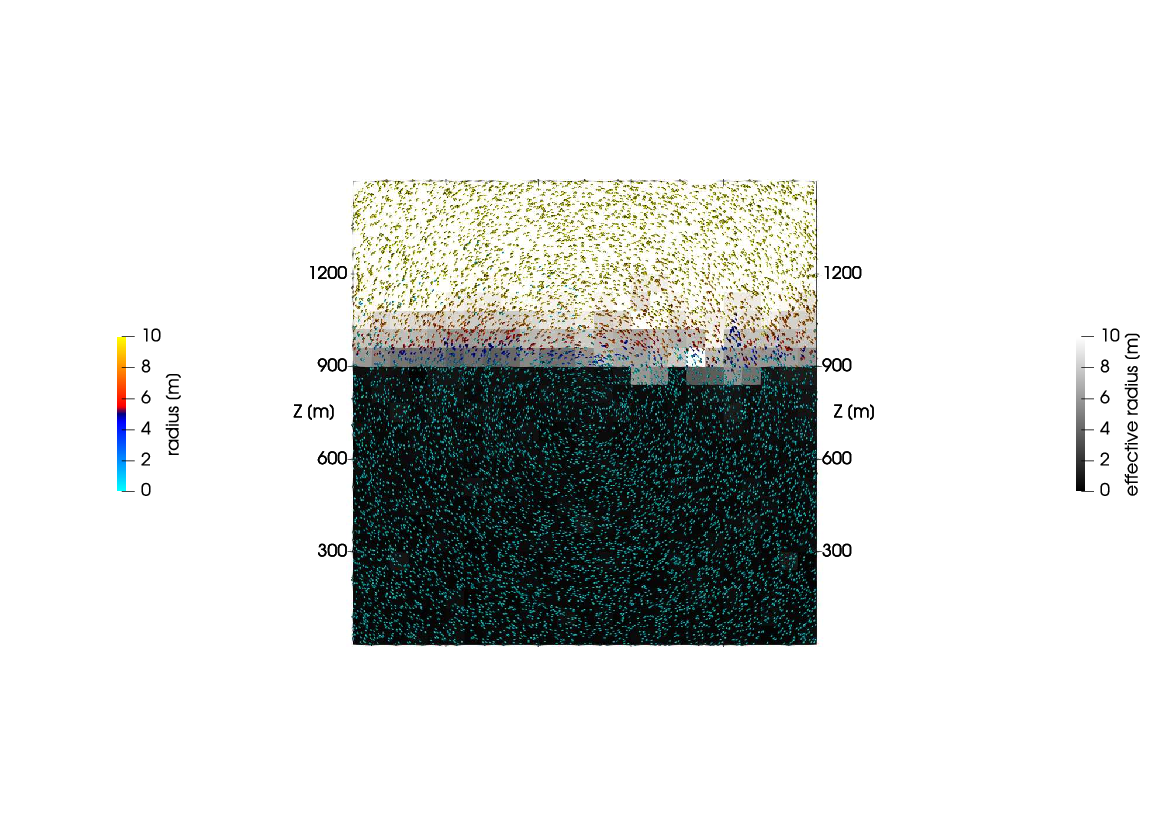

In [59]:
def pdf2png(pdf_file, png_file):
    page = 1
    resolution = 100
    subprocess.run(
        ("gs",
         "-q",
         "-dNOPAUSE",
         "-dBATCH",
         "-sDEVICE=pngalpha",
         "-r" + str(resolution),
         "-dPDFFitPage",
         "-sOutputFile=" + png_file,
         "-dFirstPage=" + str(page),
         "-dLastPage=" + str(page),
         pdf_file
        ),
        stdout=open(os.devnull, 'w'),
        stderr=subprocess.STDOUT,
        check=True
    )

pdf2png(selected_frame, selected_frame + '.png')

display(Image(selected_frame + ".png"))